# Import and settings

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from snaptools import manipulate as man
from snaptools import snapio
from snaptools import plot_tools
from snaptools import utils
from scipy.stats import binned_statistic
from mpl_toolkits.axes_grid1 import Grid

from snaptools import simulation
from snaptools import snapshot
from snaptools import measure
from pathos.multiprocessing import ProcessingPool as Pool


from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import pandas as PD
from scipy.interpolate import interp2d

colors = ['#332288', '#CC6677', '#6699CC', '#117733']
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rc('lines', linewidth=3)
%matplotlib inline


# Snapshot

In [54]:
settings = plot_tools.make_defaults(first_only=True, com=True, xlen=20, ylen=20, in_min=0)
snap = io.load_snap('/usr/users/spardy/coors2/hpc_backup/working/Gas/Dehnen_LMC/collision/output_Dehnen_smc_45deg/snap_007.hdf5')
velfield = snap.to_velfield(parttype='gas', write=False, first_only=True, com=True)
centDict = snap.find_centers(settings)
com1, com2, gal1id, gal2id = snap.center_of_mass('stars')

velx = snap.vel['stars'][gal1id, 0]
vely = snap.vel['stars'][gal1id, 1]
velz = snap.vel['stars'][gal1id, 2]
posx = snap.pos['stars'][gal1id, 0]
posy = snap.pos['stars'][gal1id, 1]
posz = snap.pos['stars'][gal1id, 2]

posx -= com1[0]
posy -= com1[1]
posz -= com1[2]

x_axis = np.linspace(-15, 15, 512)
y_axis = x_axis
X, Y = np.meshgrid(x_axis, y_axis)
angle = np.arctan2(X, Y)
R = np.sqrt(X**2 + Y**2)*(-1)**(angle < 0) 
# Use arctan to make all R values negative on other side of Y axis


In [72]:
#sparse_vfield = snap.to_velfield(lengthX=10, lengthY=10, BINS=128, write=False, first_only=True, com=True)

settings = plot_tools.make_defaults(first_only=True, com=True, xlen=10, ylen=10, in_min=0, BINS=128)
Z2 = snap.to_cube(theta=45, write=False, first_only=True, com=True, BINS=128, lengthX=10, lengthY=10)
mom1 = np.zeros((128, 128))
velocities = np.linspace(-200, 200, 100)
for i in xrange(Z2.shape[2]):
    mom1 += Z2[:,:,i]*velocities[i]

mom1 /= np.sum(Z2, axis=2)
sparse_vfield = mom1

sparse_vfield[sparse_vfield != sparse_vfield] = 0
sparse_X, sparse_Y = np.meshgrid(np.linspace(-10, 10, 128), np.linspace(-10, 10, 128))
with file('./vels_i45deg.txt', 'w') as velfile:
    velfile.write('       X          Y      VEL        EVEL\n')
    velfile.write('      asec       asec    km/s       km/s\n')
    velfile.write('-----------------------------------------\n')
    for xi, yi, vi in zip(sparse_X.flatten(), sparse_Y.flatten(), sparse_vfield.flatten()):
        velfile.write('%3.2f    %3.2f    %3.2f    0.001\n' % (xi, yi, vi))

In [89]:
com1, com2, gal1id, gal2id = snap.center_of_mass('stars')
v1 = snap.vel['stars'][gal1id, :].mean(axis=0)
v2 = snap.vel['stars'][gal2id, :].mean(axis=0)
print(np.sqrt(np.sum((v1-v2)**2)))

255.248


# Measure Velocities from Velfield

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan   6.46727908   6.31208713   6.91340601          nan
  12.430347            nan  18.06400333  20.09083625  22.40071167
  26.33220346  27.68547241  24.03372598  16.96297342  12.68978974
   7.77657353   0.34139155   8.32692741  16.42985223  24.54370133
  33.14937827  41.9204495   45.05136749  47.80114574          nan
          nan  50.64748577  50.67692256  51.60935358          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan]
0.399565865949
[          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan  109.75483322  107.53620024  104.92182311
  101.33595623   97.22460616   87.78463693   68.85196684   55.13417006
   49.65257987   39.54559096   27.112748

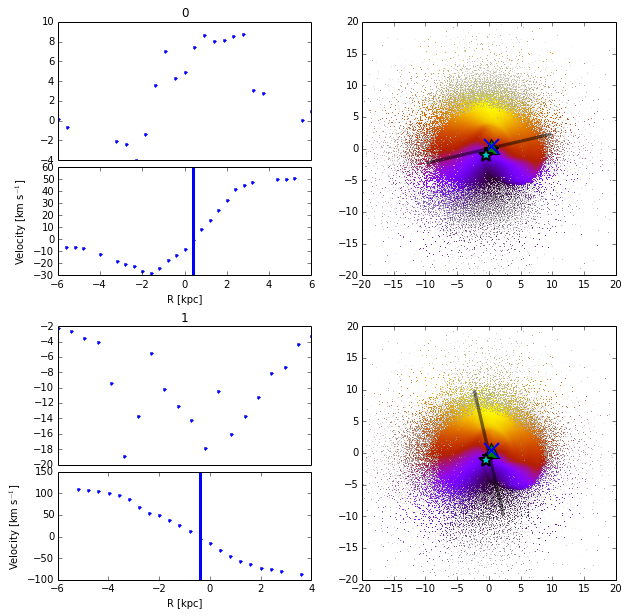

In [71]:
# Now try with the velfield
settings = plot_tools.make_defaults(first_only=True, com=True, xlen=20, ylen=20, in_min=0)
binDict = snap.bin_snap(settings)
Z2 = binDict['Z2']
measurements = man.fit_contours(Z2, settings, plot=True)
#measurementsV2 = man.fit_contours(~np.isnan(velfield), settingsV, plot=True, numcontours=1)

length = 10
thick = 0.1 
codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
if len(np.where(measurements['eccs'] > 0.5)[0]) > 0:
    bar_ind = np.max(np.where(measurements['eccs'] > 0.5)[0])
    theta = measurements['angles'][bar_ind]
else:
    theta = measurements['angles'][measurements['angles'] == measurements['angles']][-1]
    
#print(theta)
r = 0

im = axes[1].imshow(velfield, origin='lower', extent=[-20, 20, -20, 20], cmap='gnuplot')
im = axes[3].imshow(velfield, origin='lower', extent=[-20, 20, -20, 20], cmap='gnuplot')

#fig.colorbar(im)
#axes[1].add_artist(measurementsV['ellipses'][0])
#axes[3].add_artist(measurementsV2['ellipses'][0])


for i, t in enumerate(np.radians([theta, theta+90])):
    x = r*np.sin(t)
    y = r*np.cos(t)
    verts = [
             [length*np.cos(t)-thick*np.sin(t)-x,
              length*np.sin(t)+thick*np.cos(t)+y],
             [length*np.cos(t)+thick*np.sin(t)-x,
              length*np.sin(t)-thick*np.cos(t)+y],
             [-length*np.cos(t)+thick*np.sin(t)-x,
              -length*np.sin(t)-thick*np.cos(t)+y],
             [-length*np.cos(t)-thick*np.sin(t)-x,
              -length*np.sin(t)+thick*np.cos(t)+y],
             [0, 0]]
    path = Path(verts, codes)
    within_box = path.contains_points(np.array([X.flatten(), Y.flatten()]).T)
    s = R.flatten()[within_box].argsort()
    dist = R.flatten()[within_box][s]
    vel = velfield.flatten()[within_box][s]
    vel, binEdges, binNum = binned_statistic(dist, vel, bins=50)
    
    rcoord = binEdges[np.nanargmin(np.abs(vel))] 
    print(np.abs(vel))
    print(rcoord)
    axes[i*2].set_title(str(i))
    divider = make_axes_locatable(axes[i*2])
    axOff = divider.append_axes("bottom", size=1.5, pad=0.1)
    axes[i*2].set_xticks([])
    axOff.set_xlabel('R [kpc]')
    axOff.set_ylabel('Velocity [km s$^{-1}$]')
    axOff.axvline(x=rcoord)
    
    axOff.plot(binEdges[:-1], vel, 'b.')
    axes[i*2].plot(binEdges[:-2], np.diff(vel), 'b.')
    #diffs = np.abs(np.diff(vel))
    #if np.any(diffs == diffs):
        
    #rcoord = binEdges[np.nanargmax(np.abs(np.diff(vel)))]
    xcoord = np.cos(t)*rcoord
    ycoord = np.sin(t)*rcoord

    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.5)
    axes[1+2*i].add_patch(patch)
        #axes[1+2*i].text((1+length)*np.cos(t)-thick*np.sin(t)-x,
        #                 (1+length)*np.sin(t)+thick*np.cos(t)+y,
        #                 str(i), fontsize=15, color='black')

    axes[1+2*i].plot(xcoord, ycoord, 'k+', markersize=15, markeredgewidth=2)
    axes[1+2*i].plot(centDict['barCenter'][0], centDict['barCenter'][1], 'g^', markersize=15, markeredgewidth=1, markerfacecolor=None)
    axes[1+2*i].plot(centDict['haloCenter'][0], centDict['haloCenter'][1], 'bx', markersize=15, markeredgewidth=2)
    axes[1+2*i].plot(centDict['diskCenters'][0], centDict['diskCenters'][1], 'c*', markersize=15, markeredgewidth=2)

    
    centDict
    
#plt.tight_layout()
plt.show()

In [70]:
print np.nanargmin(np.abs(vel))
print binEdges[np.nanargmin(np.abs(vel))]

24
-0.399565865949


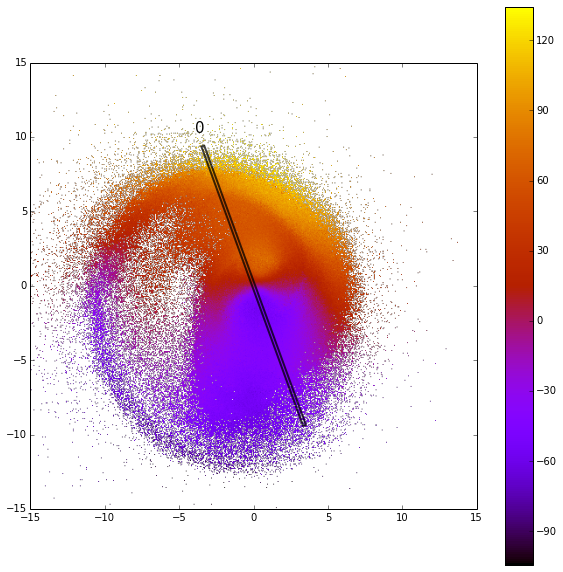

In [222]:
#fig, axes = plt.subplots(1, 2, figsize=(20, 10))

fig, axis = plt.subplots(1, figsize=(10,10))
#plot_tools.plot_contours(density, measurements, 0, -1, [0, 0], settings, axis=axis)

im = axis.imshow(velfield, origin='lower', extent=[-15, 15, -15, 15], cmap='gnuplot')
#axes[1].imshow(mom1, origin='lower', extent=[-15, 15, -15, 15], cmap='gnuplot')
fig.colorbar(im)

length = 10
thick = 0.1 

codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]
    
theta = 110
for i, r in enumerate(xrange(-5, 5, 1)):
    x = r*np.sin(np.radians(theta))
    y = r*np.cos(np.radians(theta))
    verts = [
             [length*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta))-x,
              length*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta))+y],
             [length*np.cos(np.radians(theta))+thick*np.sin(np.radians(theta))-x,
              length*np.sin(np.radians(theta))-thick*np.cos(np.radians(theta))+y],
             [-length*np.cos(np.radians(theta))+thick*np.sin(np.radians(theta))-x,
              -length*np.sin(np.radians(theta))-thick*np.cos(np.radians(theta))+y],
             [-length*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta))-x,
              -length*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta))+y],
             [0, 0]]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.75)
    axis.add_patch(patch)
    axis.text((1+length)*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta))-x,
              (1+length)*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta))+y,
              str(i), fontsize=15, color='black')

#axes[0].set_xlim(-15,15)
#axes[0].set_ylim(-15,15)

In [ ]:
# Now try with the velfield
length = 10
thick = 0.1 
codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]

fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()
theta = np.radians(110)
for i, r in enumerate(xrange(-5, 5, 1)):
    x = r*np.sin(theta)
    y = r*np.cos(theta)
    verts = [
             [length*np.cos(theta)-thick*np.sin(theta)-x,
              length*np.sin(theta)+thick*np.cos(theta)+y],
             [length*np.cos(theta)+thick*np.sin(theta)-x,
              length*np.sin(theta)-thick*np.cos(theta)+y],
             [-length*np.cos(theta)+thick*np.sin(theta)-x,
              -length*np.sin(theta)-thick*np.cos(theta)+y],
             [-length*np.cos(theta)-thick*np.sin(theta)-x,
              -length*np.sin(theta)+thick*np.cos(theta)+y],
             [0, 0]]
    path = Path(verts, codes)
    within_box = path.contains_points(np.array([X.flatten(), Y.flatten()]).T)
    s = Y.flatten()[within_box].argsort()
    dist = Y.flatten()[within_box][s]
    vel = velfield.flatten()[within_box][s]
    vel, binEdges, binNum = binned_statistic(dist, vel, bins=50)
    axes[i].set_title(str(i))
    divider = make_axes_locatable(axes[i])
    axOff = divider.append_axes("bottom", size=1, pad=0.1)
    axes[i].set_xticks([])

    axOff.plot(binEdges[:-1], vel, 'b.')
    axes[i].plot(binEdges[:-2], np.diff(vel), 'b.')
    xcoord = binEdges[np.nanargmax(np.abs(np.diff(vel)))]
    ycoord = np.tan(theta)*xcoord
    print(xcoord, ycoord)  
    
#plt.tight_layout()
plt.show()


ERROR:astropy:ValueError: not a file or file object (Invalid arguments to routine: Inappropriate type)


ValueError: not a file or file object (Invalid arguments to routine: Inappropriate type)

ERROR: ValueError: not a file or file object (Invalid arguments to routine: Inappropriate type) [IPython.core.interactiveshell]


In [11]:
!ls ../

Astro715_HW3.ipynb	  Illustris.ipynb	  plottingtest.ipynb
Data			  Impact_parameter.ipynb  PythonNotebooks
Dehnen_Burkert_fit.ipynb  isima_notebooks	  Stream_Notebooks
Ellipse_Stuff.ipynb	  llustrisPlots.ipynb	  test.out
GalCoords.ipynb		  Mathematica_Notebooks   TestPotential.ipynb
Haro11.ipynb		  Offsets_Notebooks	  vels_i45deg.txt
Haro11_planning.ipynb	  outfile.txt


##Plot 2d velocities vs. disk fit

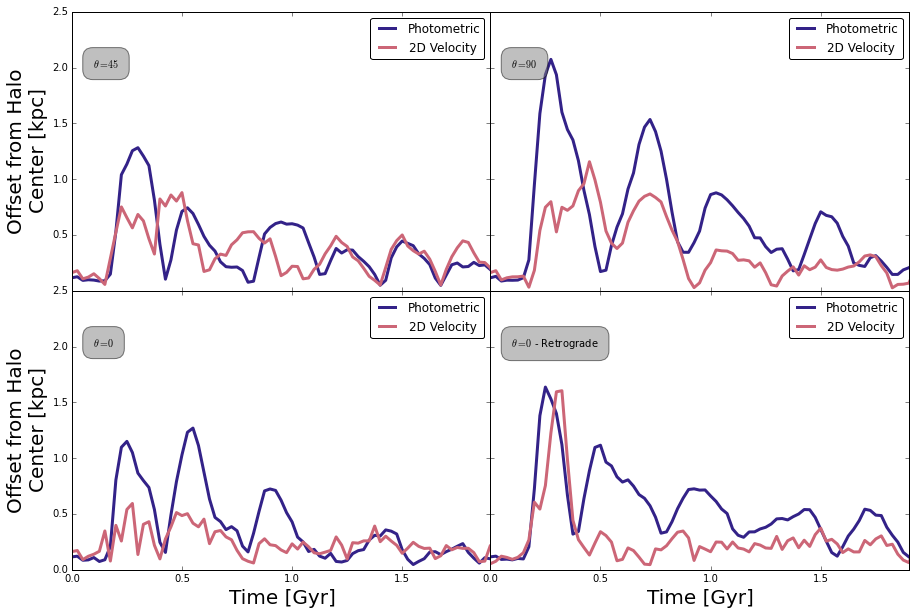

In [25]:
names = [r'$\theta = 45$', r'$\theta = 90$',
         r'$\theta = 0$', r'$\theta = 0$ - Retrograde']

fig = plt.figure(figsize=(15, 10))
colors = ['#332288', '#CC6677', '#6699CC', '#117733']
grid = Grid(fig, 111,
            nrows_ncols=(2, 2),
            axes_pad=0.0,
            label_mode="L",
            share_all=True
            )

groups = ['45deg',
          '90deg',
          '0deg',
          '0deg_retro']

for group, ax in zip(groups, grid):
    with h5py.File('../Data/offSetsDehnen_best.hdf5', 'r') as offsets:
        centers = offsets['/stars/%s/' % group]
        haloCenters = centers['halo_pos'][()]
        diskCenters = centers['disk_pos'][()]
        times = centers['time'][()]
    
        velcents2d = np.loadtxt('/usr/users/spardy/coors/data/2dVels/xy_%s.txt' % group)
        velcents2d = np.array(velcents2d).reshape(len(velcents2d)/2, 2, order='F')


        ax.plot(times[:-1],
                  np.sqrt(np.sum((diskCenters[:-1, :]-haloCenters[:-1, :])**2, axis=1)),
                  label='Photometric')

        ax.plot(times[:-1],
                  np.sqrt(np.sum((velcents2d-haloCenters[:-1, :])**2, axis=1)),
                  label='2D Velocity', color=colors[1])     
    
for i, (ax, name) in enumerate(zip(grid, names)):
    if i == 0: 
        yticks = ax.yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
    ax.set_xlim(0, 1.9)
    #ax.set_ylim(0, 4.0)
    #ax.errorbar([-0.75], [1.1], yerr=distErrs, label='Typical Error')
    ax.legend(fancybox=True, loc='upper right')
    if (i == 0) or (i == 2):
        ax.set_ylabel('Offset from Halo \nCenter [kpc]', fontsize=20)
        #axOff.set_ylabel('D$_{Disk}$ - D$_{Bar}$ \n [kpc]', fontsize=20)
    ax.set_xlabel("Time [Gyr]", fontsize=20)
    ax.annotate(name, xy=(0.05, 0.8), color='black', xycoords='axes fraction',
                bbox=dict(facecolor='gray', edgecolor='black',
                          boxstyle='round, pad=1', alpha=0.5))
    

plt.subplots_adjust(wspace=0.04)  # Default is 0.2
plt.savefig('../../Offsets_paper/plots/velocity_centers.pdf', dpi=600)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22.5, 7.5))

with h5py.File('/usr/users/spardy/velocity_offsets.hdf5', 'r') as velFile:
    grp = velFile['Dehnen_45deg/']

    velcents2d = np.loadtxt('/usr/users/spardy/coors/data/2dVels/xy.txt')
    velcents2d = np.array(velcents2d).reshape(len(velcents2d)/2, 2, order='F')

    # Minor Axis
    
    velCenters = np.sqrt(np.sum(grp['velCenters'][()]**2, axis=1))
    velCent = velCenters[:, 1]
    axes[0].plot(times, velCent, zorder=-1, label='Minor-Axis', color=colors[1], linestyle='--')
  
    velCent = PD.rolling_mean(velCenters[:, 1], 3)
    
    times = grp['time'][()]
    axes[0].plot(times, np.sqrt(np.sum(grp['diskCenters'][()]**2, axis=1)), label='Disk')

    axes[0].plot(times, velCent, zorder=-1, label='Avg.', color='gray')

    # major axis
    
    velCent = velCenters[:, 0]
    axes[1].plot(times, velCent, zorder=-1, label='Major-Axis', color=colors[1], linestyle='--')
  
    velCent = PD.rolling_mean(velCenters[:, 1], 3)
    
    axes[1].plot(times, np.sqrt(np.sum(grp['diskCenters'][()]**2, axis=1)), label='Disk')

    axes[1].plot(times, velCent, zorder=-1, label='Avg.', color='gray')    

    # 2d fit
    
    axes[2].plot(times, np.sqrt(np.sum(grp['diskCenters'][()]**2, axis=1)), label='Disk')

    axes[2].plot(times, np.sqrt(np.sum(velcents2d**2, axis=1)), label='2D Velocity', color=colors[1])

    
for axis in axes:
    axis.legend()    
    axis.set_xlabel('Time [Gyr]')
    axis.set_ylabel('Distance from Frame Center [kpc]')

In [51]:
data = np.loadtxt("/usr/users/spardy/coors/data/2dVels/vel008_0.txt", skiprows=3, usecols=(0,1,2))
model = np.loadtxt("/usr/users/spardy/coors/data/2dVels/LMC_OUT_0/vel008_0.mod", skiprows=2, usecols=(0,1,2))

#dataX = data[:, 0].reshape(256, 256)
#dataY = data[:, 1].reshape(256, 256)
dataZ = data[:, 2].reshape(256, 256)
print dataZ.shape
#ataF = interp2d(data[:, 0], data[:, 1], data[:, 2]

print model.shape
binsize = 20./256.
Xind = np.array(np.floor((model[:, 0]+10)/binsize)).astype(int)
Yind = np.array(np.floor((model[:, 1]+10)/binsize)).astype(int)

#modelX = model[:, 0].reshape(sz, sz)
#modelY = model[:, 1].reshape(sz, sz)
#modelZ = model[:, 2].reshape(sz, sz)

#XIND, YIND = np.meshgrid(Xind, Yind)

sparseImg = np.ones((256, 256))*np.nan
#sparseImg[XIND, YIND] = dataZ[XIND, YIND]

sparseModel = np.ones((256, 256))*np.nan

for xi, yi, z in zip(Xind, Yind, model[:, 2]):
    sparseModel[xi, yi] = z
    sparseImg[Xind, Yind] = dataZ[Xind, Yind]

(256, 256)
(10885, 3)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sparseImg, extent=[-10, 10, -10, 10])
axes[1].imshow(sparseModel.T, extent=[-10, 10, -10, 10])
axes[2].imshow(sparseModel.T-sparseImg, extent=[-10, 10, -10, 10])
#axes[1].plot(model[:, 0], model[:, 2])

# OLD STUFF

In [ ]:
theta = np.radians(20)
r = 0
x = r*np.sin(theta)
y = r*np.cos(theta)
verts = [
         [length*np.cos(theta)-thick*np.sin(theta)-x,
          length*np.sin(theta)+thick*np.cos(theta)+y],
         [length*np.cos(theta)+thick*np.sin(theta)-x,
          length*np.sin(theta)-thick*np.cos(theta)+y],
         [-length*np.cos(theta)+thick*np.sin(theta)-x,
          -length*np.sin(theta)-thick*np.cos(theta)+y],
         [-length*np.cos(theta)-thick*np.sin(theta)-x,
          -length*np.sin(theta)+thick*np.cos(theta)+y],
         [0, 0]]
path = Path(verts, codes)
within_box = path.contains_points(np.array([X.flatten(), Y.flatten()]).T)
s = Y.flatten()[within_box].argsort()
dist = Y.flatten()[within_box][s]
vel = velfield.flatten()[within_box][s]
vel, binEdges, binNum = binned_statistic(dist, vel, bins=50)
xcoord = binEdges[np.nanargmax(np.abs(np.diff(vel)))]
ycoord = np.tan(theta)*xcoord
print(xcoord, ycoord)

In [ ]:
# MOM1 maps
settings = plot_tools.make_defaults(first_only=True, com=True, xlen=20, ylen=20, in_min=0)
Z2 = snap.to_cube(theta=20, write=False, first_only=True, com=True)
mom1 = np.zeros((512, 512))
velocities = np.linspace(-200, 200, 100)
for i in xrange(Z2.shape[2]):
    mom1 += Z2[:,:,i]*velocities[i]

mom1 /= np.sum(Z2, axis=2)
x_axis = np.linspace(-15, 15, 512)
y_axis = x_axis
X, Y = np.meshgrid(x_axis, y_axis)
density = np.sum(Z2, axis=2)
density[density > 0] = np.log10(density[density > 0])
settings = plot_tools.make_defaults(xlen=20, ylen=20, in_min=0, in_max=6)
measurements = man.fit_contours(density, settings, plot=True)

In [ ]:
#Using the moment1 map
length = 10
thick = 0.1 
codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]

fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()
theta = np.radians(measurements['angles'][0]-90)
for i, r in enumerate(xrange(-5, 5, 1)):
    x = r*np.sin(theta)
    y = r*np.cos(theta)
    verts = [
             [length*np.cos(theta)-thick*np.sin(theta)-x,
              length*np.sin(theta)+thick*np.cos(theta)+y],
             [length*np.cos(theta)+thick*np.sin(theta)-x,
              length*np.sin(theta)-thick*np.cos(theta)+y],
             [-length*np.cos(theta)+thick*np.sin(theta)-x,
              -length*np.sin(theta)-thick*np.cos(theta)+y],
             [-length*np.cos(theta)-thick*np.sin(theta)-x,
              -length*np.sin(theta)+thick*np.cos(theta)+y],
             [0, 0]]
    path = Path(verts, codes)
    within_box = path.contains_points(np.array([X.flatten(), Y.flatten()]).T)
    s = X.flatten()[within_box].argsort()
    dist = X.flatten()[within_box][s]
    vel = mom1.flatten()[within_box][s]
    vel, binEdges, binNum = binned_statistic(dist, vel, bins=50)
    axes[i].set_title(str(i))
    divider = make_axes_locatable(axes[i])
    axOff = divider.append_axes("bottom", size=1, pad=0.1)
    axes[i].set_xticks([])

    axOff.plot(binEdges[:-1], vel, 'b.')
    axes[i].plot(binEdges[:-2], np.diff(vel), 'b.')
    
    
#plt.tight_layout()
plt.show()

In [ ]:
for i, theta in enumerate(xrange(0, 180, 18)):
    verts = [
             [length*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta)),
              length*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta))],
             [length*np.cos(np.radians(theta))+thick*np.sin(np.radians(theta)),
              length*np.sin(np.radians(theta))-thick*np.cos(np.radians(theta))],
             [-length*np.cos(np.radians(theta))+thick*np.sin(np.radians(theta)),
              -length*np.sin(np.radians(theta))-thick*np.cos(np.radians(theta))],
             [-length*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta)),
              -length*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta))],
             [0, 0]]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.75)
    axes[1].add_patch(patch)
    axes[1].text((1+length)*np.cos(np.radians(theta))-thick*np.sin(np.radians(theta)),
                 (1+length)*np.sin(np.radians(theta))+thick*np.cos(np.radians(theta)),
                 str(i), fontsize=15)

In [ ]:
x1 = 10
dy = 0.1

codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]

fig, axes = plt.subplots(2, 5, figsize=(20, 4))
axes = axes.flatten()
for i, theta in enumerate(xrange(0, 180, 18)):
    verts = [
             [x1*np.cos(np.radians(theta))-dy*np.sin(np.radians(theta)),
              x1*np.sin(np.radians(theta))+dy*np.cos(np.radians(theta))],
             [x1*np.cos(np.radians(theta))+dy*np.sin(np.radians(theta)),
              x1*np.sin(np.radians(theta))-dy*np.cos(np.radians(theta))],
             [-x1*np.cos(np.radians(theta))+dy*np.sin(np.radians(theta)),
              -x1*np.sin(np.radians(theta))-dy*np.cos(np.radians(theta))],
             [-x1*np.cos(np.radians(theta))-dy*np.sin(np.radians(theta)),
              -x1*np.sin(np.radians(theta))+dy*np.cos(np.radians(theta))],
             [0, 0]]
    path = Path(verts, codes)
    within_box = path.contains_points(np.array([X.flatten(), Y.flatten()]).T)
    axes[i].plot(X.flatten()[within_box], mom1.flatten()[within_box], 'b.')
    axes[i].set_title(str(i))
    
plt.tight_layout()
plt.show()

In [ ]:
x1 = 10
dy = 0.1

codes = [Path.MOVETO,
Path.LINETO,
Path.LINETO,
Path.LINETO,
Path.CLOSEPOLY,
]

fig, axes = plt.subplots(2, 5, figsize=(20, 4))
axes = axes.flatten()
for i, y in enumerate(xrange(-10, 10, 2)):
    verts = [
             [x1, dy+y],
             [x1, -dy+y],
             [-x1, -dy+y],
             [-x1, dy+y],
             [0, 0]]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2)
#axes[i].add_patch(patch)
#axes[i].set_xlim(-20,20)
#axes[i].set_ylim(-20,20)
    within_box = path.contains_points(np.array([posx, posy]).T)
    axes[i].plot(posx[within_box[::10]], vely[within_box[::10]], 'b.')

plt.show()

#fig = plt.figure()
#ax = fig.add_subplot(111)
#patch = patches.PathPatch(path, facecolor='none', lw=2)
#ax.add_patch(patch)
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)
#plt.show()